In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import re
from textblob import TextBlob
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import swifter
import dask.dataframe as dd
from wordcloud import WordCloud
import glob
import itertools
import folium
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [2]:
checkin=pd.read_json("./Yelp_data/Yelp/checkin.json", lines=True)

In [3]:
df=pd.read_excel("./Yelp_data/Yelp/business.xlsx")

# **EDA `checkin.json`**

In [4]:
df1=df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     150346 non-null  int64  
 1   business_id    150346 non-null  object 
 2   name           150346 non-null  object 
 3   address        145219 non-null  object 
 4   city           150346 non-null  object 
 5   state          150343 non-null  object 
 6   postal_code    150273 non-null  object 
 7   latitude       150346 non-null  float64
 8   longitude      150346 non-null  float64
 9   stars          150346 non-null  float64
 10  review_count   150346 non-null  int64  
 11  is_open        150346 non-null  int64  
 12  attributes     136602 non-null  object 
 13  categories     150243 non-null  object 
 14  hours          127123 non-null  object 
 15  business_id1   5 non-null       object 
 16  name1          5 non-null       object 
 17  address1       5 non-null    

In [5]:
df1.drop(columns="Unnamed: 0",inplace=True)
df1.drop(columns=df1.columns[14:],inplace=True)
df1.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       145219 non-null  object 
 3   city          150346 non-null  object 
 4   state         150343 non-null  object 
 5   postal_code   150273 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


La columna address no es una columna reelevante, ya que, por mas que tiene la dirección de los locales, para dar la unicacion es mejor usar la latitud y longitud. El código postal tampoco es reelevante para el analisis del trabajo teniendo la la info del estado, ciudad y coordenadas. La columna hours, donde aparecen los horarios de apertura y cierre no es útil dentro del análisis de mercado que se hará. 

In [7]:
df1.drop(columns=["address","postal_code","hours"],inplace=True)

In [8]:
df2=df1.drop_duplicates(subset="business_id",ignore_index=True)

In [9]:
print(f"Número de filas antes de tratar de eliminar los duplicados de business_id: {df1.shape[0]}")
print(f"Número de filas despues de tratar de eliminar los duplicados de business_id: {df2.shape[0]}")

Número de filas antes de tratar de eliminar los duplicados de business_id: 150346
Número de filas despues de tratar de eliminar los duplicados de business_id: 150346


Como puede verse, en esa columna no hay duplicados, es el id que identifica a cada negocio. Por lo que es la que es importante que no tenga duplicados.

En la columna categories hay 3 NaN. Como solo son 3 los rellenamos a mano 

In [10]:
df2.loc[0,"state"]="CA"
df2.loc[1,"state"]="MO"
df2.loc[2,"state"]="AZ"

In [11]:
# Convertir la columna 'categories' de una cadena separada por comas a una lista
df2['categories'] = df2['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df2["categories"].fillna("[]")
df2["categories"]=df2["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


El objetivo es ver en que estado hay un mejor ambiente para abrir un negocio. Para este fin analizaremos la cantidad de negocios por estado, la variedad de estos (la cantidad de categorías) y su calificacion promedio.

El objetivo es ver en que estado hay un mejor ambiente para abrir un negocio. Como se vió en el EDA de `business`, Pensilvania y FLorida son respectivamente los top 1 y 2 de estados con mayor número de negocios y con mayor variedad Esto hace que estos dos estados sean una buena elección para centrar nuestro análisis, ya que son los mejores estados para poner un negocio.

In [ ]:
df2_PA=df2[df2["state"]=="PA"]
df2_FL=df2[df2["state"]=="FL"]

Trabajemos ahora con el dataframe checkin 

In [14]:
checkin1=checkin.copy()
checkin1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


No hay entradas vacías

Haacemos join con los dataframe de FLorida y Pensilvania

In [16]:
df2_PA=df2_PA.merge(checkin1[["business_id", "date"]], left_on="business_id", right_on="business_id", how="left")
df2_FL=df2_FL.merge(checkin1[["business_id", "date"]], left_on="business_id", right_on="business_id", how="left")

En checkin.json faltan business_id que si estan en `bisiness.xlsx`. Ademas, hay que aclarar que, las listas de fechas en la columna date, ni empiezan ni terminan en el mismo año para todos los negocios. De esta forma no es un buen criterio de comparación. Sin embargo, se lo utilizará como dato de color para comparar.

In [17]:
df2_PA['date'] = df2_PA['date'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df2_PA["date"].fillna("[]")
df2_PA["date"]=df2_PA["date"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df2_FL['date'] = df2_FL['date'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df2_FL["date"].fillna("[]")
df2_FL["date"]=df2_FL["date"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [18]:
# Contar la cantidad de fechas en la columna 'date' para cada negocio
df2_PA['num_visits'] = df2_PA['date'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df2_FL['num_visits'] = df2_FL['date'].apply(lambda x: len(x) if isinstance(x, list) else 0)

<Figure size 1000x600 with 0 Axes>

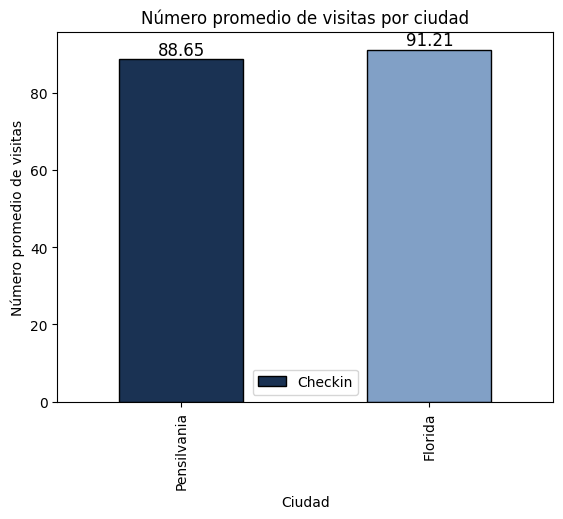

En Pensilvania, los negocios tienen 88.65013660800847 ingresos promedios a lo largo de los años
En Forida, los negocios tienen 91.2061225264917 ingresos promedios a lo largo de los años


In [ ]:
PAvsFL = pd.DataFrame({ 
    "city": ["Pensilvania", "Florida"],
    "Checkin": [df2_PA['num_visits'].mean(), df2_FL['num_visits'].mean()]
})

# Crear gráfico de barras verticales
plt.figure(figsize=(10, 6))
colors = ['#1a3253', '#81a0c6'][:len(PAvsFL)]
bars = PAvsFL.plot.bar(x='city', y='Checkin', color=colors, edgecolor='black')

# Mostrar el valor de cada barra con dos cifras significativas
for i in range(len(bars.patches)):
    bars.patches[i].set_height(bars.patches[i].get_height())  # Ajuste visual para que las barras estén bien dibujadas
    bars.text(bars.patches[i].get_x() + bars.patches[i].get_width() / 2, bars.patches[i].get_height() + 0.1, 
              f'{bars.patches[i].get_height():.2f}', 
              ha='center', va='bottom', fontsize=12)

plt.title('Número promedio de visitas por ciudad')
plt.ylabel('Número promedio de visitas')
plt.xlabel('Ciudad')
plt.show()


Aunque el dato no sea muy fiable por no estar bajo las mismas condiciones de comparación para ambos estados, En Florida se puede ver un numero de ingresos totales promedio mayor que el de Pensilvania. Esto puede traducirse en que el florida hay mas actividad diaria. 

Con este análisis concluímos que **nos quedaremos con los negocios de Florida**. Ademas, como se vió en el EDA de `business`, **se filtrará también por restoranes**.

In [20]:
# Asegurarse de que la columna 'categories' contiene listas (si está en formato string, convertirla)
df2['categories'] = df2['categories'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Aplanar la lista de categorías y contar frecuencia
category_counts = Counter(itertools.chain.from_iterable(df2['categories'].dropna()))

# Convertir a DataFrame
df_categories = pd.DataFrame(category_counts.items(), columns=['Category', 'Frequency'])

# Filtrar categorías que contengan "restaurant", "food" o "bar" como palabras completas
filtered_categories = df_categories[df_categories["Category"].str.contains(r"restaurant|food|\b(bar)\b", case=False, na=False)]

# Mostrar las primeras filas del filtrado
print(filtered_categories.head(20))

                   Category  Frequency
17              Restaurants      52268
18                     Food      27781
25                Fast Food       6472
41              Food Trucks       1273
78                  Seafood       3539
109          Specialty Food       4233
148                Beer Bar        870
210  Food Delivery Services       1050
241     Do-It-Yourself Food        145
243           Live/Raw Food         88
329               Soul Food        539
356             Ethnic Food        658
359              Food Tours         62
366            Comfort Food        746
380             Food Stands        423
386         Seafood Markets        337
482           Imported Food        201
523               Bar Crawl         26
739              Food Court        130
926      Pop-Up Restaurants         75


C:\Users\maria\AppData\Local\Temp\ipykernel_11820\2593701408.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_categories = df_categories[df_categories["Category"].str.contains(r"restaurant|food|\b(bar)\b", case=False, na=False)]


In [21]:
# Importamos el csv que tiene las ciudades de FLorida y su población
ciudades=pd.read_csv("./Google_Maps_data/florida_population.csv")
ciudades1=ciudades.copy()
ciudades1.dropna(inplace=True)

In [22]:
# Sacamos las mayúsculas a los nombres de las cuidades
ciudades_list = set(ciudades1["City"].str.lower().str.strip())
df2["city"] = df2["city"].str.lower().str.strip()
# Filtramos solo por las ciudades que están en Florida
df2_Florida = df2[df2["city"].isin(ciudades_list)]
# Convertir las categorías permitidas en un conjunto en minúsculas
allowed_categories = set(filtered_categories["Category"].str.lower().str.strip())
# Separar la columna 'category' en filas individuales (una categoría por fila)
df2_Florida_exploded = df2_Florida.explode('categories')
# Convertir a minúsculas y quitar espacios extra para evitar problemas
df2_Florida_exploded['categories'] = df2_Florida_exploded['categories'].str.lower().str.strip()
# Filtrar solo las filas donde la categoría está en allowed_categories
df2_Florida_rest = df2_Florida_exploded[df2_Florida_exploded['categories'].isin(allowed_categories)]


# **EDA `tip.json`**

In [23]:
tips = pd.read_json("./Yelp_data/Yelp/tip.json", lines=True)

In [24]:
tips1=tips.copy()
tips1

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
...,...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57,0
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36,0
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56,0
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44,0


In [25]:
tips1=tips1.merge(df2[["business_id","city"]], left_on="business_id", right_on="business_id", how="left")
tips1=tips1.merge(df2[["business_id", "stars"]], left_on="business_id", right_on="business_id", how="left")
tips1=tips1.merge(df2[["business_id", "is_open"]], left_on="business_id", right_on="business_id", how="left")
tips1=tips1.merge(df2[["business_id", "categories"]], left_on="business_id", right_on="business_id", how="left")
tips1=tips1.merge(df2[["business_id", "attributes"]], left_on="business_id", right_on="business_id", how="left")

tips1.reset_index(drop=True,inplace=True)

In [26]:
# Asegurarse de que la columna 'categories' contiene listas (si está en formato string, convertirla)
df2['categories'] = df2['categories'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Aplanar la lista de categorías y contar frecuencia
category_counts = Counter(itertools.chain.from_iterable(df2['categories'].dropna()))

# Convertir a DataFrame
df_categories = pd.DataFrame(category_counts.items(), columns=['Category', 'Frequency'])

# Filtrar categorías que contengan "restaurant", "food" o "bar" como palabras completas
filtered_categories = df_categories[df_categories["Category"].str.contains(r"restaurant|food|\b(bar)\b", case=False, na=False)]

# Mostrar las primeras filas del filtrado
print(filtered_categories.head(20))

                   Category  Frequency
17              Restaurants      52268
18                     Food      27781
25                Fast Food       6472
41              Food Trucks       1273
78                  Seafood       3539
109          Specialty Food       4233
148                Beer Bar        870
210  Food Delivery Services       1050
241     Do-It-Yourself Food        145
243           Live/Raw Food         88
329               Soul Food        539
356             Ethnic Food        658
359              Food Tours         62
366            Comfort Food        746
380             Food Stands        423
386         Seafood Markets        337
482           Imported Food        201
523               Bar Crawl         26
739              Food Court        130
926      Pop-Up Restaurants         75


C:\Users\maria\AppData\Local\Temp\ipykernel_11820\2593701408.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_categories = df_categories[df_categories["Category"].str.contains(r"restaurant|food|\b(bar)\b", case=False, na=False)]


In [27]:
# Importamos el csv que tiene las ciudades de FLorida y su población
ciudades=pd.read_csv("./Google_Maps_data/florida_population.csv")
ciudades1=ciudades.copy()
ciudades1.dropna(inplace=True)

# Sacamos las mayúsculas a los nombres de las cuidades
ciudades_list = set(ciudades1["City"].str.lower().str.strip())
tips1["city"] = tips1["city"].str.lower().str.strip()
# Filtramos solo por las ciudades que están en Florida
tips1_Florida = tips1[tips1["city"].isin(ciudades_list)]
# Convertir las categorías permitidas en un conjunto en minúsculas
allowed_categories = set(filtered_categories["Category"].str.lower().str.strip())
# Separar la columna 'category' en filas individuales (una categoría por fila)
tips1_Florida_exploded = tips1_Florida.explode('categories')
# Convertir a minúsculas y quitar espacios extra para evitar problemas
tips1_Florida_exploded['categories'] = tips1_Florida_exploded['categories'].str.lower().str.strip()
# Filtrar solo las filas donde la categoría está en allowed_categories
tips1_Florida_rest = tips1_Florida_exploded[tips1_Florida_exploded['categories'].isin(allowed_categories)]

tips1_Florida_rest.reset_index(drop=True,inplace=True)


In [28]:
# Verificar la cantidad de valores nulos en cada columna
missing_values = tips1_Florida_rest.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
missing_values = missing_values[missing_values > 0]
# Mostrar el resultado
if missing_values.empty:
    print("No hay valores nulos en el DataFrame.")
else:
    print("Valores nulos por columna:")
    print(missing_values)

Valores nulos por columna:
attributes    196
dtype: int64


In [29]:
tips1_Florida_rest.loc[:, "attributes"] = tips1_Florida_rest["attributes"].fillna("{}")

**Análisis de sentimiento de los comentarios**

In [30]:
# Separar comentarios positivos y negativos
positive_tips = tips1_Florida_rest[tips1_Florida_rest['stars'] >= 4.5]
negative_tips = tips1_Florida_rest[tips1_Florida_rest['stars'] <= 1]

# Vectorizar palabras más comunes
vectorizer = CountVectorizer(stop_words='english', max_features=20)
positive_words = vectorizer.fit_transform(positive_tips['text'])
negative_words = vectorizer.fit_transform(negative_tips['text'])

# Palabras más frecuentes en positivas
positive_freq = pd.DataFrame(
    positive_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

# Palabras más frecuentes en negativas
negative_freq = pd.DataFrame(
    negative_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

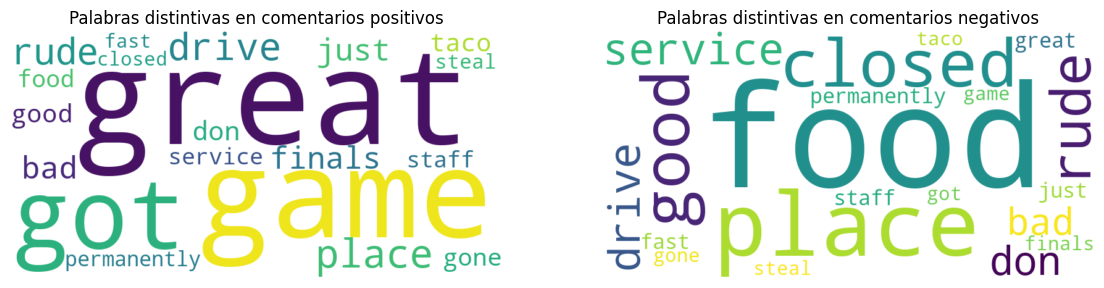

In [31]:
# Definir un umbral de diferencia para considerar una palabra distintiva
threshold = 500  # Ajusta según necesidad

# Calcular diferencia de frecuencia
word_differences = (positive_freq - negative_freq).abs()

# Filtrar palabras que tienen una diferencia significativa en frecuencia asegurando índices coincidentes
positive_distinct = positive_freq.loc[word_differences['frequency'] > threshold]
negative_distinct = negative_freq.loc[word_differences['frequency'] > threshold]

# Crear nubes de palabras con términos más diferenciadores
wordcloud_positive_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(positive_distinct['frequency'].to_dict())

wordcloud_negative_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(negative_distinct['frequency'].to_dict())

# Mostrar las nuevas nubes de palabras
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en comentarios positivos')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en comentarios negativos')

plt.show()

In [32]:
# Definir el tamaño del chunk
chunk_size = 500000  # Procesar en bloques de 5000 comentarios

# Función de análisis de sentimiento
def analyze_sentiment(text):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from textblob import TextBlob

    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

# Iterar sobre los datos en chunks
for start in range(0, len(tips1_Florida_rest), chunk_size):
    end = min(start + chunk_size, len(tips1_Florida_rest))
    chunk = tips1_Florida_rest.iloc[start:end].copy()  # Copia para evitar modificaciones en el DataFrame original

    # Aplicar análisis de sentimiento con swifter
    chunk[['vader_score', 'textblob_score']] = chunk['text'].swifter.apply(lambda x: analyze_sentiment(str(x))).apply(pd.Series)

    # 🔹 Guardar cada chunk en un archivo Parquet para no perder datos
    chunk.to_parquet(f"sentiment_chunk_{start}.parquet")

    print(f"✅ Procesado y guardado chunk {start}-{end}")


Pandas Apply:   0%|          | 0/186363 [00:00<?, ?it/s]

✅ Procesado y guardado chunk 0-186363


In [33]:
# Definir el tamaño del chunk
chunk_size = 50000  # Procesar en bloques de 50000 comentarios

# Buscar todos los archivos de chunks ya guardados
chunk_files = glob.glob("sentiment_chunk_*.parquet")

# Cargar los chunks procesados en un solo DataFrame
if chunk_files:
    processed_chunks = [pd.read_parquet(f) for f in chunk_files]
    processed_tips = pd.concat(processed_chunks, ignore_index=True)
    print(f"✅ Cargados {len(processed_tips)} comentarios ya procesadas.")
else:
    processed_tips = pd.DataFrame()  # Si no hay chunks, empezar de cero
    print("⚠️ No se encontraron chunks previos, procesando todo desde el inicio.")

✅ Cargados 186363 comentarios ya procesadas.


In [34]:
# Filtrar las comentarios que faltan procesar
remaining_tips = tips1_Florida_rest[~tips1_Florida_rest['text'].isin(processed_tips['text'])]

print(f"📌 Comentarios pendientes por procesar: {len(remaining_tips)}")

📌 Comentarios pendientes por procesar: 0


In [35]:
chunk_size = 500000  # Procesar en bloques de 5000 comentarios

# Función de análisis de sentimiento
def analyze_sentiment(text):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from textblob import TextBlob

    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

# Iterar sobre los datos en chunks y continuar desde donde quedó
for start in range(0, len(remaining_tips), chunk_size):
    end = min(start + chunk_size, len(remaining_tips))
    chunk = remaining_tips.iloc[start:end].copy()

    # Aplicar análisis de sentimiento con swifter
    chunk[['vader_score', 'textblob_score']] = chunk['text'].swifter.apply(lambda x: analyze_sentiment(str(x))).apply(pd.Series)

    # Guardar cada chunk en un archivo
    chunk.to_parquet(f"sentiment_chunk_{start}.parquet")

    print(f"✅ Procesado y guardado chunk {start}-{end}")

In [36]:
# Buscar todos los archivos guardados
chunk_files = glob.glob("sentiment_chunk_*.parquet")

# Cargar y combinar todos los chunks
tips_final = pd.concat([pd.read_parquet(f) for f in chunk_files], ignore_index=True)

# Verificar que todo esté unido
print(f"Dataset final: {tips_final.shape[0]} filas, {tips_final.shape[1]} columnas")

Dataset final: 186363 filas, 12 columnas


El Vader Score calificó a 18176 comentarios como negativos, a 129183 como positivos y a 39004 como neutros
El TextBlob Score calificó a 20885 comentarios como negativos, a 129581 como positivos y a 39004 como neutros 



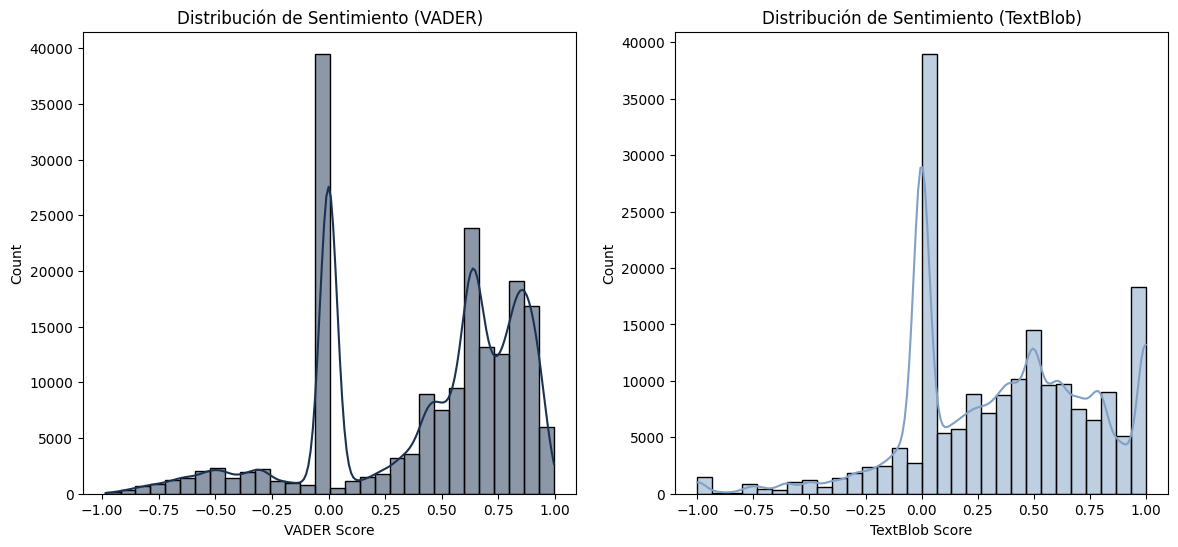

In [67]:
# Separamos  los valores positivos del vader_score de los negativospara contarlos 
negativo_VR=tips_final[tips_final['vader_score']<0]
positivo_VR=tips_final[tips_final['vader_score']>0]
neutro_VR=tips_final[tips_final['vader_score']==0]
# Separamos  los valores positivos del textblob_score de los negativospara contarlos 
negativo_TB=tips_final[tips_final['textblob_score']<0]
positivo_TB=tips_final[tips_final['textblob_score']>0]
neutro_TB=tips_final[tips_final['vader_score']==0]

print(f'El Vader Score calificó a {negativo_VR.shape[0]} comentarios como negativos, a {positivo_VR.shape[0]} como positivos y a {neutro_VR.shape[0]} como neutros')
print(f'El TextBlob Score calificó a {negativo_TB.shape[0]} comentarios como negativos, a {positivo_TB.shape[0]} como positivos y a {neutro_TB.shape[0]} como neutros','\n')

plt.figure(figsize=(14, 6))

# VADER
plt.subplot(1, 2, 1)
sns.histplot(tips_final['vader_score'], bins=30, kde=True, color='#1a3253')
plt.title("Distribución de Sentimiento (VADER)")
plt.xlabel("VADER Score")

# TextBlob
plt.subplot(1, 2, 2)
sns.histplot(tips_final['textblob_score'], bins=30, kde=True, color='#81a0c6')
plt.title("Distribución de Sentimiento (TextBlob)")
plt.xlabel("TextBlob Score")

plt.show()

In [38]:
tips_final["sentiment_label_VADER"] = tips_final["vader_score"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
tips_final["sentiment_label_TextBlob"] = tips_final["textblob_score"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

**Conclución para cada gráfica:**
- Para el `Vader Score` nos da una un pico muy agudo en valores neutros, superando a los negativos. Si nos fijamos en el número de comentarios positivos, negativos y neutros, el primero supera en un orden de magnitud a los demás.
- Lo mismo ocurre para los resultados del `TextBlob Score`.

In [39]:
def expand_subdicts(df):
    for col in df.columns:
        try:
            df_expanded = df[col].dropna().apply(ast.literal_eval).apply(pd.Series)
            df_expanded = df_expanded.add_prefix(f"{col}_")  # Agregar prefijo
            df = pd.concat([df.drop(columns=[col]), df_expanded], axis=1)
        except (ValueError, SyntaxError, TypeError):
            pass  # Si no se puede convertir, ignorar
    return df

tips2=tips1_Florida_rest.copy()
tips2['attributes'].fillna("{}")
tips2['attributes']=tips2['attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Usamos json_normalize para desanidar la columna 'info'
atributos_df = pd.json_normalize(tips2['attributes'])
atributos_df1=expand_subdicts(atributos_df)

# Convertir valores "True/False" en 1/0
atributos_df1 = atributos_df1.map(lambda x: 1 if str(x).lower() == 'true' else (0 if str(x).lower() == 'false' else x))

# Reemplazar NaN con 0 para evitar problemas
atributos_df1 = atributos_df1.fillna(0)

# Concatenamos las nuevas columnas al dataframe original
tips2 = pd.concat([tips2.drop(columns='attributes'), atributos_df1], axis=1)

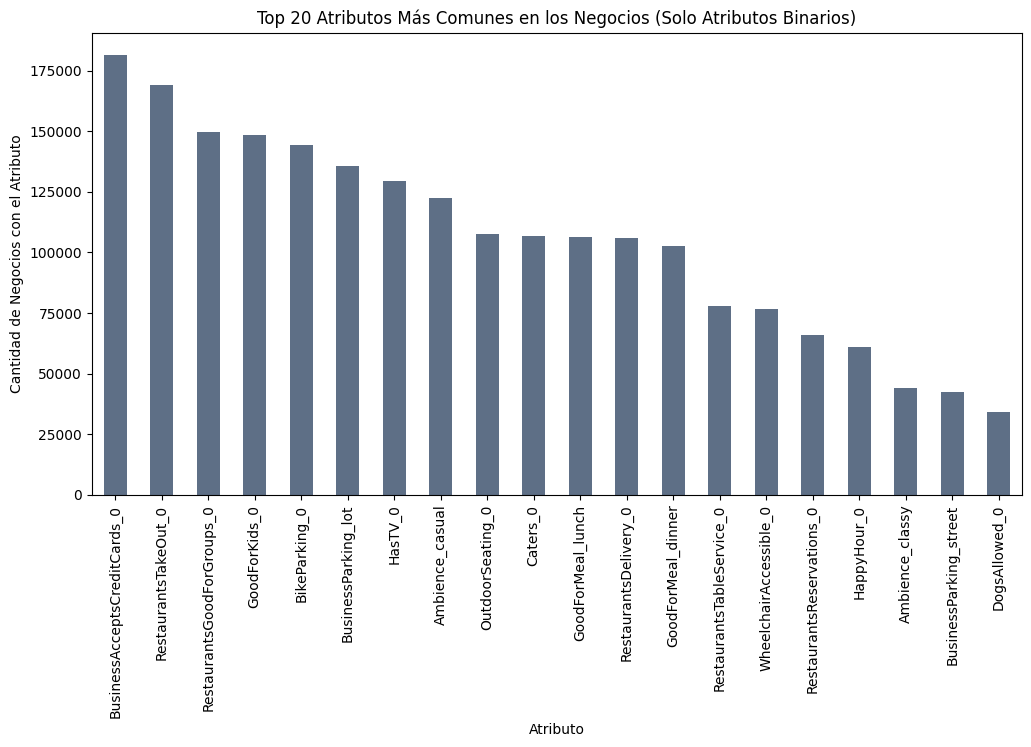

In [64]:
# Definir las columnas irrelevantes que queremos excluir
columns_to_exclude = ['business_id',"user_id", 'name',"text","date","compliment_count","clean_text","sentiment","sentiment_label","state","stars","is_open","categories",
                      'RestaurantsPriceRange2_0',"NoiseLevel_0"]  # Excluir rango de precios porque no es binario

# Seleccionar solo las columnas de atributos binarios
attribute_columns = [col for col in tips2.columns if col not in columns_to_exclude]
# Sumar la cantidad de negocios que tienen cada atributo activado
attribute_counts = tips2[attribute_columns].apply(pd.to_numeric, errors='coerce').sum().sort_values(ascending=False)

# Gráfico de barras con los atributos más comunes
plt.figure(figsize=(12, 6))
attribute_counts.head(20).plot(kind="bar", color="#1a3253", alpha=0.7)
plt.title("Top 20 Atributos Más Comunes en los Negocios (Solo Atributos Binarios)")
plt.ylabel("Cantidad de Negocios con el Atributo")
plt.xlabel("Atributo")
plt.xticks(rotation=90)
plt.show()

In [41]:
attribute_counts2=attribute_counts.reset_index()
attribute_counts2

,index,0
0,BusinessAcceptsCreditCards_0,181534.0
1,RestaurantsTakeOut_0,168951.0
2,RestaurantsGoodForGroups_0,149565.0
3,GoodForKids_0,148427.0
4,BikeParking_0,144225.0
...,...,...
74,DietaryRestrictions_vegetarian,0.0
75,DietaryRestrictions_kosher,0.0
76,DietaryRestrictions_vegan,0.0
77,DietaryRestrictions_dairy-free,0.0


In [42]:
tips_florida_completo=pd.concat([tips2, tips_final[["sentiment_label_VADER","sentiment_label_TextBlob"]]],axis=1)

C:\Users\maria\AppData\Local\Temp\ipykernel_11820\1108942597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tips_florida_completo_filtred1[['sentiment_label_VADER','sentiment_label_TextBlob']] = tips_florida_completo_filtred1[['sentiment_label_VADER','sentiment_label_TextBlob']].replace(-1, 0)


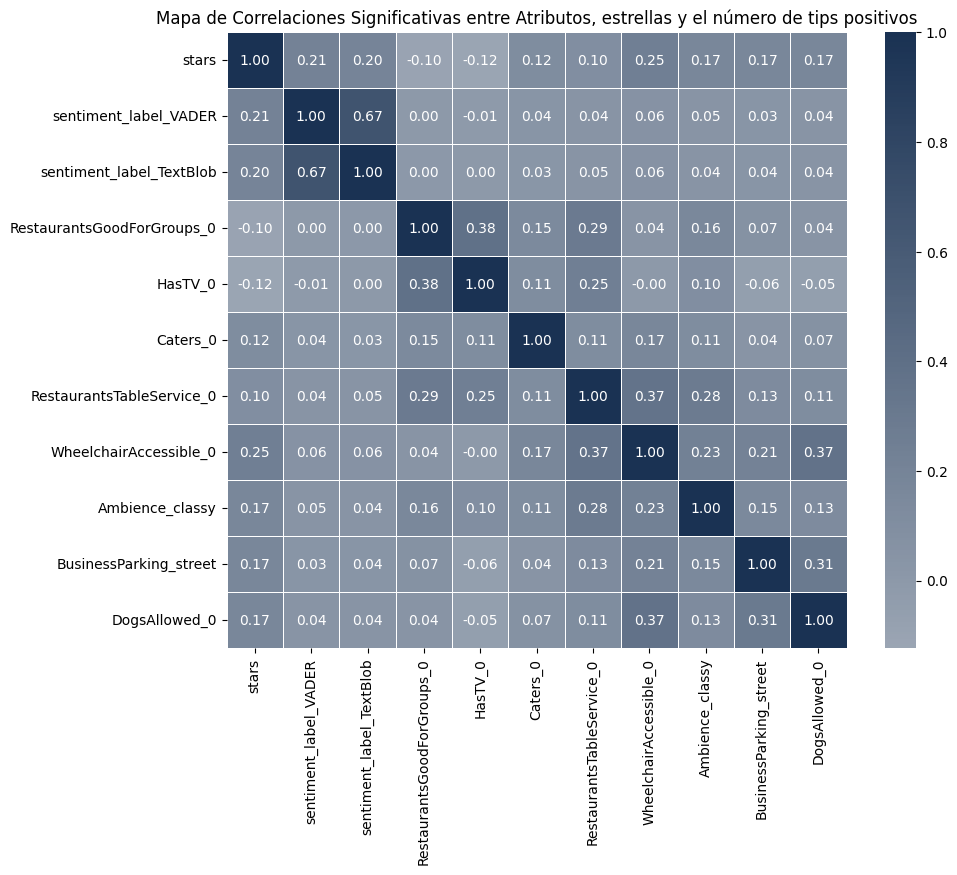

In [85]:
# Hacemos un filtro para sacar del análisis a los comentarios neutros
tips_florida_completo_filtred = tips_florida_completo[tips_florida_completo['sentiment_label_VADER']!=0]
tips_florida_completo_filtred1 = tips_florida_completo_filtred[tips_florida_completo_filtred['sentiment_label_TextBlob']!=0]
tips_florida_completo_filtred1[['sentiment_label_VADER','sentiment_label_TextBlob']] = tips_florida_completo_filtred1[['sentiment_label_VADER','sentiment_label_TextBlob']].replace(-1, 0)
# Seleccionar solo las columnas numéricas relevantes
correlation_data = pd.concat([tips_florida_completo_filtred1[['stars','sentiment_label_VADER','sentiment_label_TextBlob']], tips_florida_completo_filtred1[[col for col in attribute_counts2.loc[:19,"index"]]]], axis=1)
# Calcular la matriz de correlación
correlation_matrix = correlation_data.corr()

# Filtrar las columnas con correlación significativa |corr| > 0.1
significant_corr = correlation_matrix[abs(correlation_matrix["stars"]) > 0.1].index
filtered_corr_matrix = correlation_matrix.loc[significant_corr, significant_corr]

# Definir los colores
colors = ['#FFFFFF','#1a3253']
# Crear un mapa de colores personalizado
custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)
# Crear el gráfico de calor usando el mapa de colores personalizado
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5, center=0)

# Personalizar el gráfico
plt.title("Mapa de Correlaciones Significativas entre Atributos, estrellas y el número de tips positivos")
plt.show()

Primero analicemos que es cada atributo:
- `WheelchairAccessible`: que el restaurant esté adaptado para gente con silla de ruedas. 
- `Businessparking_street`: tener lugar de estacionamiento para clientes sobre la calle.
- `Ambience_classy`: tener un ambiente mas sofisticado y elegante.
- `DogsAllowed`: Se permiten perros.
- `RestaurantsTableService`: tener servicio de mesa.
- `HasTV`: tiene televisión en el local.
- `Caters`: el lugar ofrece servicios de catering o comida para eventos especiales
- `RestaurantsGoodForGroups`: el lugar tiene características que favorecen a que las personas vayan en grupos, como por ejemplo espacio amplio, menú para compartir, reservas para grupos, etc.

**Concluciónes de la gráfica:**
- _Correlación entre los tips positivos dados por ambos métodos:_ se puede ver que la correlacion entre `Vander_Score` y `TextBlob_Score` es muy alta, esto hace que sea casi equivalente utilizar un método u otro para hacer el análisis de sentimiento de los tips. 
- _Correlación entre "stars" y los tips positivos dados por ambos métodos:_ se puede ver casi la misma correlación positiva entre las estrellas del restoran y los tips positivos de ambos métodos.
- _Correlación entre los tips positivos dados por ambos métodos y los atriburos mas reelevantes para las estrellas:_ como puede verse la correlación entre el número de tips positivos y los atributos es positiva, pero muy poco reelevante.
- _Correlación entre "stars" los atriburos:_ 
    - Correlacion positiva: los únicos atributos que tienen una correlacion relevante positiva con el número de estrellas son `WheelchairAccessible`, `Businessparking_street`, `Ambience_classy`, `DogsAllowed`, `Caters` y `RestaurantsTableService` (en ese orden de importancia).
    - Correlacion negativa: los únicos atributos que tienen una correlacion relevante negativa con el número de estrellas son `HasTV` y `RestaurantsGoodForGroups`. 

Como conclución podemos decir que para mejorar la calificación es importante adaptar el negocio a personas en silla de ruedas, tener estacionamiento exclusivo para clientes en la calle, tener un estilo mas elegante, servicio de mesa y tener servicio de catering (permitir perros puede ir en contra del hambiente elegante pero tambien). Por otro lado, tener televicion puede molestar a las personas por distracción y hacer que califiquen mas bajo, ademas de que aceptar grupos muy grandes puede aportar a la incomodidad de los clientes por el ruido y la cantidad de personas dentro de un mismo espacio. Además, el hecho de que los tips positivos tengan correlación con la calificacion, pero no con los atributos que hacen a un mayor número de estas, nos hace pensar que, en realidad, esa correlación se interpreta como que el tener un número alto de estrellas te lleva a mas tips positivos y no al reves.  